In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age["age"].mean() > 80:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "PnP PowerShell",
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
eDiscovery,409.895635,7.590660,41.424366,54
Ubuntu,230.211005,8.854269,54.577785,26
Network Terms,218.042720,14.536181,59.514307,15
"The Mines of the Behemoth, Shea",1138.816343,23.241150,112.930756,49
Exchange Online and Defender,997.015101,25.564490,76.869702,39
"Everything is Tuberculosis, Green",687.439908,29.888692,123.037304,23
SSH + SCP,905.579163,31.226868,182.603250,29
Docker,1275.585662,41.147925,185.350753,31
Linux,1361.925498,42.560172,164.481908,32
WinHex,968.190170,46.104294,162.732420,21


# Histogram

sum of ages: ~46886.04


<Axes: >

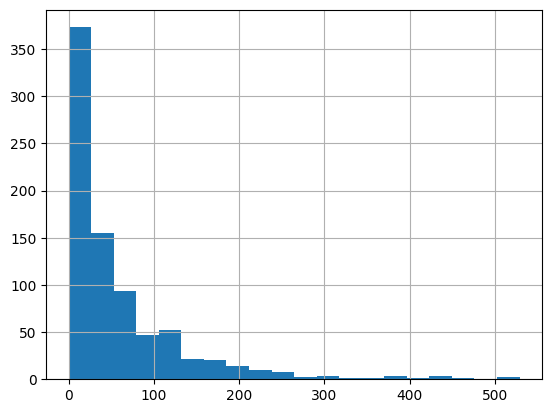

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~46886.04


<Axes: >

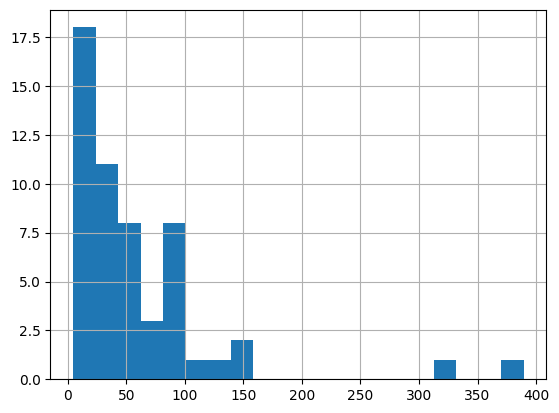

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

modulo for n-fold
Cards found: 812
Total card age: 46886.04


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
130,Accounting,Reconciliation\nComparing records from two sou...,81a1a67b91258e37f9d7563aaded7aab,178.479269,92.264777,-178.479269,461.323886,0.733790,5,0,0,-178.479269
678,Accounting,Retained Earnings\nThe cumulative net income o...,1150d1bf321129bc7ed28e668af16c6b,63.200210,92.264777,-178.479269,461.323886,0.733790,5,3,0,-63.200210
349,TSQL,CASE Expressions:\n\nImplements conditional lo...,f017d6e7d5dc77052491955f455502ce,179.371975,93.859830,-179.371975,750.878642,0.642041,8,0,0,-179.371975
68,TSQL,Table Variables:\n\nDeclared using DECLARE and...,268660150f0a42727427b3701cbd014e,91.813016,93.859830,-179.371975,750.878642,0.642041,8,3,0,-91.813016
69,TSQL,Transactions and Isolation Levels:\n\nUse BEGI...,519d1a0e21ed53955a9fa74fa1345325,43.715335,93.859830,-179.371975,750.878642,0.642041,8,6,0,-43.715335
19,Power BI,Q: What is the effect of data type mismatches ...,237db394d61828ffc8fdd92606a5ca49,224.338388,102.535586,-224.338388,1025.355865,0.269549,10,0,0,-224.338388
17,Power BI,Q: Name one alternative to the SQL connector w...,d215c14635d1ea280211553f930a2ef4,191.960564,102.535586,-224.338388,1025.355865,0.269549,10,3,0,-191.960564
298,Power BI,What’s the difference between SUMMARIZE and SU...,e9ad423a7671d3e507054436d1b536aa,24.621819,102.535586,-224.338388,1025.355865,0.269549,10,6,0,-24.621819
573,Power BI,Q: What is “query folding” and why does it mat...,959c28c5aca25deb0808145cac595fb8,15.957203,102.535586,-224.338388,1025.355865,0.269549,10,9,0,-15.957203
241,Network Terms,RADIUS – Common Use Cases\n\nEnterprise Wi-Fi ...,2bf730f4bed4bb4e3ad035f1fa3f6b5e,59.514307,14.536181,-59.514307,218.042720,0.669069,15,0,0,-59.514307



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1072.9720858193411)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
365,Azure Files Documentation,"When using AD DS authentication, you assign sh...",c93dfdaf4065533896f6a7ba95b7d4ca,528.937031,80.527466,-528.937031,3704.263432,0.121066,46,0,0,-528.937031
90,Azure Files Documentation,The Kerberos authentication client is implemen...,d9d78220383e95f5f8155f911a8d65c0,502.741913,80.527466,-528.937031,3704.263432,0.121066,46,1,1,-502.741913
579,Terraform Codebox,CIFS (Common Internet File System)\nA network ...,121c60b48a3d689b6c1fde3868727aa2,475.240163,107.064370,-475.240163,3747.252959,0.387178,35,0,0,-475.240163
5,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,435.114504,101.965329,-435.114504,3670.751829,0.389277,36,0,0,-435.114504
580,Terraform Codebox,Cloud-init is a standard way to initialize Lin...,784c88e3c53824bb061271636376695d,430.964601,107.064370,-475.240163,3747.252959,0.387178,35,1,1,-430.964601
608,Node.js and Vite,Import Alias Validation (shadcn)\nshadcn check...,1a0e173e6fcc0c538da9bbb2d6113267,429.723495,87.553258,-429.723495,3151.917275,0.575112,36,0,0,-429.723495
303,Terraform Codebox,exercism configure\nA CLI command used to link...,ca713604b27c9413cd735061438bbcb1,409.318797,107.064370,-475.240163,3747.252959,0.387178,35,2,2,-409.318797
657,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,389.669638,58.588153,-389.669638,3163.760271,0.817854,54,0,0,-389.669638
548,Django,Collectstatic Step\nPart of Django deployment ...,52e99cf555a329f05921f2a497c12457,378.945731,97.511777,-378.945731,1560.188431,0.556760,16,0,0,-378.945731
286,JavaScript Concepts,Split a string and convert parts to numbers\n ...,e4c93ec49febdd31af930f9d8321ee49,376.559886,101.965329,-435.114504,3670.751829,0.389277,36,1,1,-376.559886


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 57.741'